# Model Training Jupyter Notebook

### Importing packages and loading data

In [20]:
# Imports
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as g
from scipy.stats import uniform, randint
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error

from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.inspection import permutation_importance

In [21]:
### Importing data
# Reading data
df_train = pd.read_csv('data/train_logs.csv', 
                 header=0)
df_test = pd.read_csv('data/test_logs.csv', 
                 header=0)
df_train_scores = pd.read_csv('data/train_scores.csv')

df_train.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


### Feature Engineering

In [22]:
def word_constructor(df):
    """
    Group words in a DataFrame based on the 'activity' column.

    Parameters:
    df (DataFrame): The input DataFrame containing the 'activity' column.

    Returns:
    DataFrame: The modified DataFrame with additional columns 'word_start' and 'word_end' indicating the boundaries of words.
    """
    
    # Initialize columns for word beginnings and endings
    df['word_start'] = 0
    df['word_end'] = 0
    
    # Shifting the activity columns up and down one for subsequent calculations
    shifted_activity_prev = df['activity'].shift(1)
    shifted_activity_next = df['activity'].shift(-1)
    
    # Identification of word boundaries
    df['word_start'] = ((df['activity'] == 'Input') & (shifted_activity_prev != 'Input')).astype(int)
    df['word_end'] = ((df['activity'] == 'Input') & (shifted_activity_next != 'Input')).astype(int)
    
    # Handling edge cases: adressing first and last column of dataframe
    df.at[0, 'word_start'] = int(df.iloc[0]['activity'] == 'Input')
    df.at[df.index[-1], 'word_end'] = int(df.iloc[-1]['activity'] == 'Input')
    
    return df

In [23]:
#def sentence_constructor(df):

In [24]:
def features(df):
    
    # Create a DataFrame to store the features with a single column of IDs
    features = pd.DataFrame({'id': df['id'].unique()})
    
    df = word_constructor(df)
    #df = sentence_constructor(df)


    # Calculate IKI for all events
    df['iki'] = df['down_time'].diff().fillna(0)

    # Initialize columns for intra-word IKI and inter-word IKI with NaN
    df['intra_word_iki'] = np.nan
    df['inter_word_iki'] = np.nan

    # Identify the start and end of words
    word_starts = df['word_start'] == 1
    word_ends = df['word_end'] == 1

    # Compute intra-word and inter-word IKI
    df.loc[word_starts, 'inter_word_iki'] = df.loc[word_starts, 'iki']
    df.loc[~word_starts & ~word_ends, 'intra_word_iki'] = df.loc[~word_starts & ~word_ends, 'iki']
    
    # IKI FEATURES

    # Computing median, standard deviation, and maximum IKI, intra-word IKI, and inter-word IKI

    agg_functions = ['median', 'std', 'max']
    iki_basics = df.groupby('id')['iki'].agg(agg_functions).reset_index()
    intra_word_iki_basics = df.groupby('id')['intra_word_iki'].agg(agg_functions).reset_index()
    inter_word_iki_basics = df.groupby('id')['inter_word_iki'].agg(agg_functions).reset_index()

    # Renaming the columns
    iki_basics.columns = ['id'] + [f'iki_{f}' for f in agg_functions]
    intra_word_iki_basics.columns = ['id'] + [f'intra_word_iki_{f}' for f in agg_functions]
    inter_word_iki_basics.columns = ['id'] + [f'inter_word_iki_{f}' for f in agg_functions]

    # Computing number of IKIs within length intervals
    
    # Define the length intervals
    #intervals = [0.5, 1, 1.5, 2, 2.5, 3, np.inf]
    

    # Merging IKI features
    features = features.merge(iki_basics, on='id')
    features = features.merge(intra_word_iki_basics, on='id')
    features = features.merge(inter_word_iki_basics, on='id')

    # Calculate the word count for each user
    word_count = df.groupby('id')['word_start'].sum().reset_index()
    features = features.merge(word_count, on='id')
    
    # Calculate the words per minute for each user by dividing the word count by the timestamp of the last event
    features['wpm'] = features['word_start'] / (df.groupby('id')['up_time'].max().reset_index()['up_time']/1000/60)

    # REVISION FEATURES
    
    return features

In [25]:
features_train = features(df_train)
features_test = features(df_test)

In [26]:
# Merging training features with training scores
df_train_merged = features_train.merge(df_train_scores, on='id')

# Splitting the merged data into features and target variable
X_train = df_train_merged.drop(['id', 'score'], axis=1)  # Dropping 'id' as it's not a feature
y_train = df_train_merged['score']

X_test = features_test.drop('id', axis=1)  # Dropping 'id' as it's not a feature

### Hyperparameter Tuning

In [27]:
# Define the parameter distribution
param_dist = {
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'min_samples_leaf': randint(1, 4),
    'max_leaf_nodes': randint(31, 51),
    'max_iter': randint(100, 300),
    'l2_regularization': uniform(0, 1)
}

# Initialize the model
model = HistGradientBoostingRegressor()

# Initialize the random search model
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', verbose=1, random_state=42)

# Fit the random search model
random_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'l2_regularization': 0.7300393165618185, 'learning_rate': 0.01954322553832976, 'max_depth': 4, 'max_iter': 243, 'max_leaf_nodes': 49, 'min_samples_leaf': 1}


### K-Fold CV, Model Training and Preliminary Evaluation

In [28]:
# Doing K-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

mse_scores = []

# Loop over each fold
for train_index, val_index in kf.split(X_train):
    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]


    # Create and train the model
    model = HistGradientBoostingRegressor(**random_search.best_params_)
    model.fit(X_train_fold, y_train_fold)

    # Make predictions on the validation set and calculate MSE
    y_val_pred = model.predict(X_val_fold)
    mse = mean_squared_error(y_val_fold, y_val_pred)
    mse_scores.append(mse)

# Calculate the average MSE across all folds
average_mse = np.mean(mse_scores)
median_mse = np.median(mse_scores)
print("Average Mean Squared Error across folds (training):", average_mse)
print("Median Mean Squared Error across folds (training):", median_mse)

Average Mean Squared Error across folds (training): 0.5756465480887429
Median Mean Squared Error across folds (training): 0.5917178806800643


In [29]:
# Predict
y_test_pred = model.predict(X_test)

### Test Prediction (for Kaggle)

In [30]:
submission = pd.DataFrame({
    'id': features_test['id'],
    'score': y_test_pred
})

# Export the submission DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)

In [31]:
print(y_test_pred)

[3.03786344 1.80315817 2.66569514]


### Model Evaluation

##### Feature Importance

In [32]:
# Calculate permutation importance
perm_importance = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)

# Prepare data for plotting
feature_names = X_train.columns
importances_df = pd.DataFrame({'features': feature_names, 'importance': perm_importance.importances_mean})

# Create the initial figure
fig = px.bar(importances_df.sort_values('importance', ascending=False),
             x='importance', 
             y='features',
             title='Permutation Feature Importances from HistGradientBoostingRegressor',
             labels={'features': 'Features', 'importance': 'Importance'},
             orientation='h')

# Customize the colors of the bars
cm = px.colors.sequential.Viridis
n_colors = len(importances_df)
fig.for_each_trace(
    lambda t: t.update(
        marker=dict(
            color=[cm[i % len(cm)] for i in range(n_colors)],
            line=dict(color='black', width=1),
            opacity=0.8
        )
    )
)

# Update layout for white background
fig.update_layout(
    paper_bgcolor='white',
    plot_bgcolor='white',
    yaxis={'categoryorder': 'total ascending'},
    xaxis_title='Importance',
    yaxis_title='Feature',
    showlegend=False,
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='lightgrey')
)

# Show the plot
fig.show()

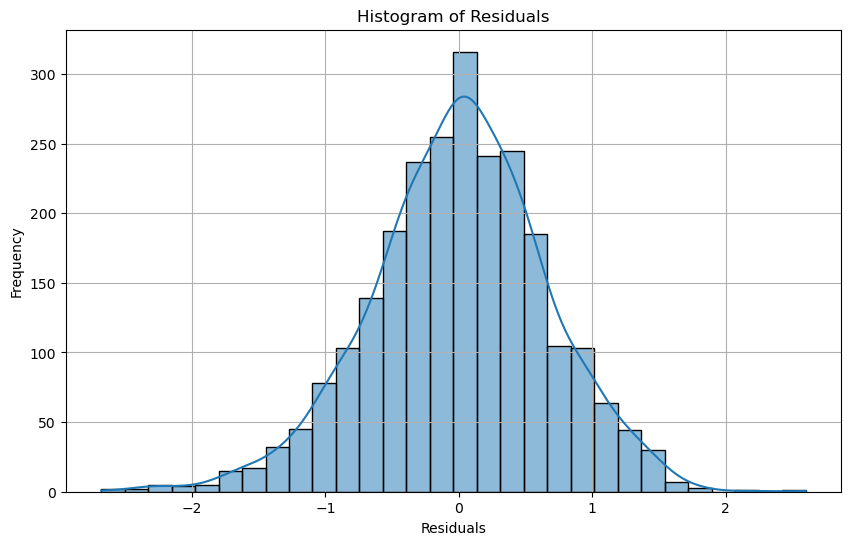

In [33]:
y_pred = model.predict(X_train)
residuals = y_train - y_pred

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

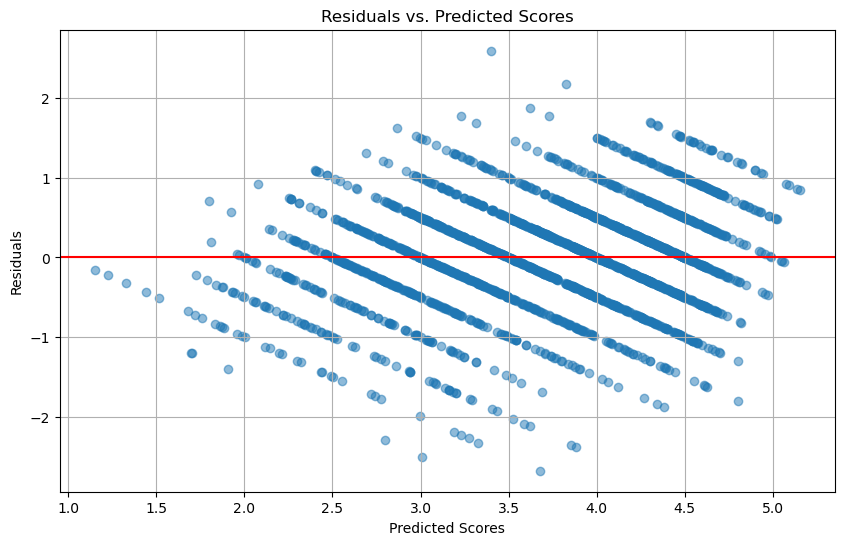

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals vs. Predicted Scores')
plt.xlabel('Predicted Scores')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

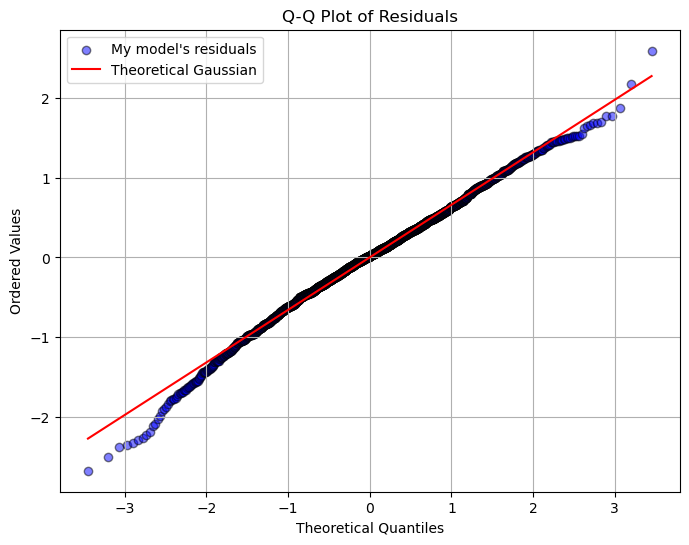

In [35]:
# Generate Q-Q plot data
qq = stats.probplot(residuals, dist="norm")

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the data points: blue inner color with alpha 0.5 and black border, label for legend
scatter = plt.scatter(qq[0][0], qq[0][1], facecolor='blue', edgecolor='black', alpha=0.5, label="My model's residuals")

# Plot the reference line (red line along the nominal path), label for legend
line = plt.plot(qq[0][0], qq[1][1] + qq[1][0] * qq[0][0], color='r', linestyle='-', label='Theoretical Gaussian')

# Customizing plot
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.grid(True)

# Add legend
plt.legend(handles=[scatter, line[0]], loc='best')

# Show the plot
plt.show()